In [25]:
#import necessary libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,6
%matplotlib inline

import math
from datetime import datetime as dt

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima_model import ARIMA

In [20]:
data=pd.read_csv("Dataset/monthly-beer-production-in-austr.csv")
data.head()

,Month,Monthly beer production in Australia
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [14]:
#test data
d1='1956-01'
print(d1[:4])
print(d1[5:])

1956
01


In [21]:
data['Month']=data['Month'].apply(lambda x: dt(int(x[:4]),int(x[5:]),15))
data['Month'].head(3)

0   1956-01-15
1   1956-02-15
2   1956-03-15
Name: Month, dtype: datetime64[ns]

In [22]:
data=data.set_index('Month')
data.head()

,Monthly beer production in Australia
Month,
1956-01-15,93.2
1956-02-15,96.0
1956-03-15,95.2
1956-04-15,77.1
1956-05-15,70.9


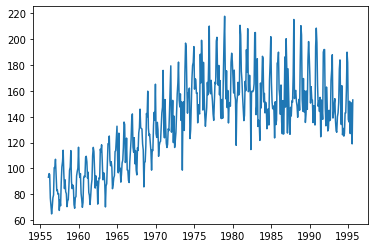

In [23]:
#assign beer prod data to time series variable
ts=data['Monthly beer production in Australia']
plt.plot(ts)

In [24]:
#from the above plot it is clear there is overall increase in the trend with some seasionality in it

<h2>Stationarity check- Rolling Statistic & Dickey Fuller Test</h2>

In [49]:
def test_stationarity(timeseries):
    #Visual Check: rolling statistic
    rollmean=timeseries.rolling(window=52,center=False).mean()
    rollstd=timeseries.rolling(window=52,center=False).std()
    
    #plot
    orig=plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(rollmean,color='red',label='Rolling Mean')
    std=plt.plot(rollstd,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Statistical check: Dickey Fuller Test
    print("Results of Dickey Fuller Test:")
    dftest=adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','P-value','#Lags Used',
                                        'Number of Observations Used' ])
   
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    print(dfoutput)

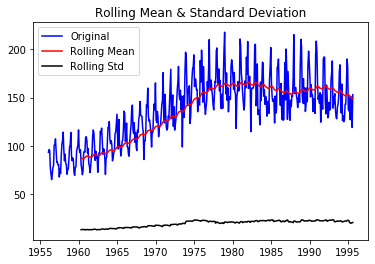

Results of Dickey Fuller Test:
Test Statistic                  -2.282661
P-value                          0.177621
#Lags Used                      17.000000
Number of Observations Used    458.000000
dtype: float64
----
Test Statistic                  -2.282661
P-value                          0.177621
#Lags Used                      17.000000
Number of Observations Used    458.000000
Critical Value (1%)             -3.444709
Critical Value (5%)             -2.867871
Critical Value (10%)            -2.570142
dtype: float64


In [50]:
test_stationarity(data['Monthly beer production in Australia'])

In [ ]:
# By observing the plot of rolling statistic plot and Dickey Value test results:
# WE infer that:
#Test statistic is more than critical value, and moving average is not constant over time. so Null Hypothesis of Dickey Fuller Test
# canot be rejected. This show that timeseries is not Stationary.

<h2>Decomposing the data</h2>

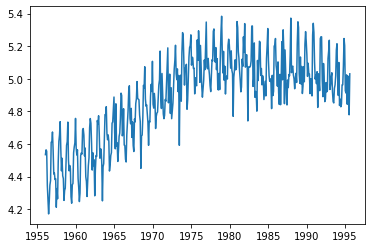

In [28]:
#transforming series using log decomposition
ts_log=np.log(ts)
plt.plot(ts_log)

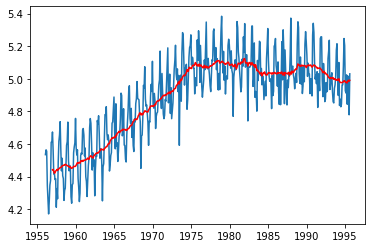

In [29]:
#initialize movingAverage & movingSTD variables
movingAverage=ts_log.rolling(window=12).mean()
movingSTD=ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(movingAverage,color='red')
#plt.plot(movingSTD,color='green')

In [31]:
ts_log_mv_diff=ts_log-movingAverage
ts_log_mv_diff.head(12)

ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(12)

Month
1956-12-15    0.231830
1957-01-15    0.118994
1957-02-15   -0.015558
1957-03-15    0.001590
1957-04-15   -0.041908
1957-05-15   -0.047399
1957-06-15   -0.225688
1957-07-15   -0.117442
1957-08-15   -0.173166
1957-09-15    0.045062
1957-10-15    0.168757
1957-11-15    0.204867
Name: Monthly beer production in Australia, dtype: float64

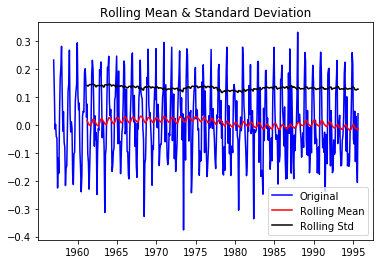

Results of Dickey Fuller Test:
Test Statistic                  -3.432559
P-value                          0.009898
#Lags Used                      13.000000
Number of Observations Used    451.000000
Critical Value (1%)             -3.444933
Critical Value (5%)             -2.867970
Critical Value (10%)            -2.570195
dtype: float64


In [32]:
test_stationarity(ts_log_mv_diff)

In [33]:
#By observing the Rolling statistic plot and Dickey fuller test results,
#shows that Test Statistic< Critical Value , therefore we can reject the Null Hypothesis.
#This series is stationary

<h2>ARIMA Model(AutoRegressiveIntegratedMovingAverage)</h2>
<h4><br> acf: identifies: MA process (Moving average) : gets p value (captures the shock effects observed in the white noise)
<br> pacf:identifies: AR process (AutoRegression) : gets q value (explains the mean and momentum reversion effects observed)
</h4>

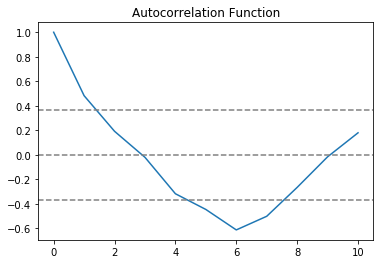

In [34]:
#plot acf
plt.plot(np.arange(0,11),acf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

In [35]:
#the acf curve crosses the upper confidence value when the lag value between 0 and 1. 
#thus the optimal value of q must be 0 or 1

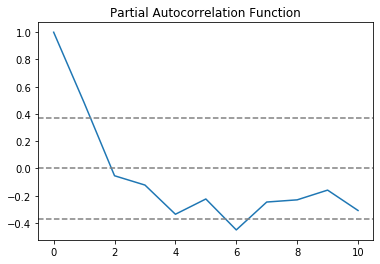

In [36]:
#plot pacf
plt.plot(np.arange(0,11),pacf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

In [37]:
#pacf curve drops to 0 between lag values 1 and 2. thus the optimal value of p is 1 or 2.5

Text(0.5, 1.0, 'RSS: nan')

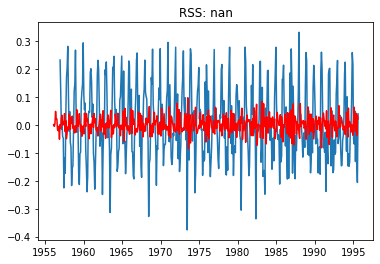

In [39]:
model=ARIMA(ts_log,order=(1,1,0))
results_ARIMA=model.fit(disp=-1)
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues[1:]-ts_log_mv_diff)**2))

In [40]:
#model predictions:
prdictions_ARIMA_diff=pd.Series(results_ARIMA.fittedvalues,copy=True)
prdictions_ARIMA_diff.head()

Month
1956-02-15    0.000936
1956-03-15   -0.005458
1956-04-15    0.003012
1956-05-15    0.048189
1956-06-15    0.019847
dtype: float64

In [41]:
# not bthe 1st month, we took a lag by 1. way to convert is

In [42]:
#find cummulitive sum
prdictions_ARIMA_diff_cummsum=prdictions_ARIMA_diff.cumsum()
prdictions_ARIMA_diff_cummsum.head()

Month
1956-02-15    0.000936
1956-03-15   -0.004522
1956-04-15   -0.001510
1956-05-15    0.046680
1956-06-15    0.066527
dtype: float64

In [43]:
#add them to base numbers and add differences to it
prdictions_ARIMA_log=pd.Series(ts_log.ix[0],index=ts_log.index)
prdictions_ARIMA_log=prdictions_ARIMA_log.add(prdictions_ARIMA_diff_cummsum,fill_value=0)
prdictions_ARIMA_log.head()

Month
1956-01-15    4.534748
1956-02-15    4.535684
1956-03-15    4.530226
1956-04-15    4.533238
1956-05-15    4.581428
dtype: float64

Text(0.5, 1.0, 'RMSE: 37.1218')

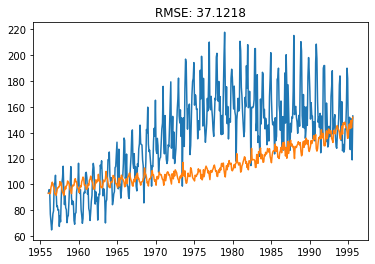

In [44]:
prdictions_ARIMA =np.exp(prdictions_ARIMA_log)
plt.plot(ts)
plt.plot(prdictions_ARIMA)
plt.title('RMSE: %.4f'%np.sqrt(sum((prdictions_ARIMA-ts)**2)/len(ts)))

In [ ]:
#orange curve is our predictions with RMSE: 52.1841
#While our model is good at predicting trend but fails in capturing seasonality. 